<a href="https://colab.research.google.com/github/alechain/transcrippcion/blob/main/transcribe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalamos las librerias necesarias

In [ ]:

# Para instalas descomentar
!pip install git+https://github.com/openai/whisper.git -q
!pip install openai
!pip install pytube

# Importamos las librerias necesarias

In [7]:
import whisper
import numpy  as np
import pandas as pd
import openai
import os
import sys
import subprocess
import requests
import regex as re
from pytube import YouTube



## Creamos unas función para descargar videos de youtube ( se puede cargar el video mp4 directo en el enviroment) y lo guardamos con el nombre de video.mp4

In [6]:
!pip install --upgrade pytube


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
!pip install youtube-dl
!pip install pafy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
url='https://www.youtube.com/watch?v=gz8dcUDO6ZU'
yt = YouTube(url,use_oauth=True, allow_oauth_cache=True)
stream_url = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first().url
response = requests.get(stream_url)
with open("video.mp4", "wb") as f:
    f.write(response.content)

### Ahora lo que viene aca es una funcioncita que basicamente convierte en fomato mp3 el audio del video que le pases (en formato mp4), para eso se usa la función ffmpeg que es una librería para gestion de videos 

In [39]:
def video2mp3(video_file, output_ext="mp3"):
    filename, ext = os.path.splitext(video_file)
    subprocess.call(["ffmpeg", "-y", "-i", video_file, f"{filename}.{output_ext}"], 
                    stdout=subprocess.DEVNULL,
                    stderr=subprocess.STDOUT)
    return f"{filename}.{output_ext}"
#aca ejecutamos la funcion con el nombre del video que creamos guardamos 
#antes
input_video = 'video.mp4'
audio_file = video2mp3(input_video)


### Con esta funcion podes escuchar el audio en el notebook para comprobar que este bien (una boludez pero sirve de testeo)

In [40]:
from IPython.display import Audio
Audio(audio_file)

### Aca importamos e instanciamos el algoritmo pre-entrenado de Whisper en size "small", esto particularmente porque se va. a correr en local se lo hace en tamaño "small". Mientras mayor sea el tamaño elegido (el tamaño importa aca) mejor serán las transcripciones y las traducciones por la cantidad de parámetros que tenga el modelo, pero a la vez mayores serán los requerimientos para poder correrlo. En mi Mac me aguante sin reventarme la memoria y el CPU hasta el tamaño small (promedio diria yo). 

### Te dejo una tablita igual con los tamaños disponibles por si querés probar otro valor (cambiar donde dice "small" por "medium" "base" et...)


| Size   | Parameters | English-only model | Multilingual model |
|--------|------------|--------------------|-------------------|
| tiny   | 39 M       |        ✓           |         ✓         |
| base   | 74 M       |        ✓           |         ✓         |
| small  | 244 M      |        ✓           |         ✓         |
| medium | 769 M      |        ✓           |         ✓         |
| large  | 1550 M     |                     |         ✓         |


In [41]:
import whisper

model = whisper.load_model("small")

## Una vez instanciado el modelo en "model" se crea una función para retornar el resultado

In [42]:
def transcribe(audio):
    
    result = model.transcribe(audio_file, fp16=False)
    return result

## Ahora si ejecutamos la función

In [43]:
result = transcribe(audio_file)


In [60]:
start=[]
end=[]
text=[]
for i in range(len(result['segments'])):
  start.append(result['segments'][i]['start'])
  end.append(result['segments'][i]['end'])
  text.append(result['segments'][i]['text'])

  

In [62]:
datos=pd.DataFrame()
datos['start']=start
datos['end']=end
datos['text']=text



In [71]:
datos['text']

0       ¿Qué virtud le encuentra Cristina Fernández d...
1        Y con sinceridad brutal es difícil, es difícil.
2       Creo que he dejado, digamos, un legado muy ne...
3                Ha profundizado muchísimo estas peleas,
4                     se han hecho muy bien en el mundo.
                             ...                        
246     al que se le rompe un árbol en la puerta de l...
247                 Le pido perdón a cada uno en el cual
248                podremos haber hecho mejor las cosas.
249                                             Gracias.
250                                      Muchas gracias.
Name: text, Length: 251, dtype: object

In [52]:
result['segments'][0]['start']

0.0

In [44]:
# abrimos el file con el nombre de transcribe
file = open('transcribe.txt', 'w')

# escribimos el resultado dentro del file
file.write(result['text'])

# lo cerramos
file.close()

# Finalizado, el archivo transcribe.txt contiene el texto transcripto del video

In [65]:
!pip install pyLDAvis

  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 2.0.1 which is incompatible.


In [66]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [70]:
result['text']

' ¿Qué virtud le encuentra Cristina Fernández de Kirchner? Y con sinceridad brutal es difícil, es difícil. Creo que he dejado, digamos, un legado muy negativo para la Argentina. Ha profundizado muchísimo estas peleas, se han hecho muy bien en el mundo. Y lo que es que es que la gente se ha hecho con la verdad es que no se ha hecho con la verdad, pero la verdad es que la gente se ha hecho con la verdad. Y la verdad es que la gente se ha hecho con la verdad. ¿Qué es lo que ha profundizado muchísimo estas peleas? ¿Esos los que no están con ellos son enemigos? ¿Y si los puedo matarlos, matos? ¿Es esta actitud? Mira, algunos que han respondido esta pregunta en su espacio político han dicho, por ejemplo, que tienen muy buena capacidad de conducción política. Bueno, es una buena oradora. Lo digo, eso no... ¿Lo moviliza gente? Bueno, sí, tiene adeptos, tiene fanáticos que la siguen, cada vez menos. ¿Qué te diga, es una buena oradora? ¿Es una virtud? En la política es. Bueno, sí, ponéle. Ponele

In [76]:
import nltk

In [78]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [79]:
!pip install spacy && python -m spacy download es_core_news_sm


In [72]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(datos['text']))

print(data_words)

[['que', 'virtud', 'le', 'encuentra', 'cristina', 'fernandez', 'de', 'kirchner'], ['con', 'sinceridad', 'brutal', 'es', 'dificil', 'es', 'dificil'], ['creo', 'que', 'he', 'dejado', 'digamos', 'un', 'legado', 'muy', 'negativo', 'para', 'la', 'argentina'], ['ha', 'profundizado', 'muchisimo', 'estas', 'peleas'], ['se', 'han', 'hecho', 'muy', 'bien', 'en', 'el', 'mundo'], ['lo', 'que', 'es', 'que', 'es', 'que', 'la', 'gente', 'se', 'ha', 'hecho', 'con', 'la', 'verdad'], ['es', 'que', 'no', 'se', 'ha', 'hecho', 'con', 'la', 'verdad'], ['pero', 'la', 'verdad', 'es', 'que', 'la', 'gente', 'se', 'ha', 'hecho', 'con', 'la', 'verdad'], ['la', 'verdad', 'es', 'que', 'la', 'gente', 'se', 'ha', 'hecho', 'con', 'la', 'verdad'], ['que', 'es', 'lo', 'que', 'ha', 'profundizado', 'muchisimo', 'estas', 'peleas'], ['esos', 'los', 'que', 'no', 'estan', 'con', 'ellos', 'son', 'enemigos'], ['si', 'los', 'puedo', 'matarlos', 'matos'], ['es', 'esta', 'actitud'], ['mira', 'algunos', 'que', 'han', 'respondido', 

In [73]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [74]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [80]:
# Spanish text analysis tools 
stopwords = set(nltk.corpus.stopwords.words("spanish"))
nlp = spacy.load("es_core_news_sm")
def normalize_tokenize_lemmatize(text):
    doc = nlp(text)
    VALID_POS = {'NOUN', 'ADJ', 'VERB', 'ADV'}
    # Avoid empty word in beggining with doc[1:]
    return [
        word.lemma_ for word in doc if word.lemma_ not in stopwords
        and word.pos_ in VALID_POS
        ]
# This step may take a few minutes
datos['text_lemma'] = datos['text'].apply(normalize_tokenize_lemmatize)

In [81]:
datos['text_lemma']

0                          [virtud, encontrar]
1       [sinceridad, brutal, difícil, difícil]
2      [creer, dejar, decir, legado, negativo]
3              [profundizar, muchísimo, pelea]
4                         [hacer, bien, mundo]
                        ...                   
246              [romper, árbol, puerta, casa]
247                            [pedir, perdón]
248                       [hacer, mejor, cosa]
249                                         []
250                                   [gracia]
Name: text_lemma, Length: 251, dtype: object

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
dictionary = Dictionary(datos['text_lemma'].to_list())
# Assign ids to every word without gaps
dictionary.compactify()
# Filter out words that appear in less than 2 documents, thos appearing in more than 97% of corpus, and keep all other words
dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
# Reassign ids to every word without gaps after filtering
dictionary.compactify()
# For every review, create a B.O.W. representation
corpus = [dictionary.doc2bow(text) for text in datos['text_lemma']]

In [83]:
# Find the optimal number of topics based on coherence
from gensim.models import LdaModel
from gensim.models import CoherenceModel

In [84]:
lm = LdaModel(corpus=corpus, num_topics = 5,
          id2word=dictionary)

In [89]:
# Find the optimal number of topics based on coherence
from gensim.models import LdaModel
from gensim.models import CoherenceModel
texts = datos['text_lemma'].to_list()
MAX_TOPICS = 5
coherence_vals = []
lm_list = []
# This loop may take a while
for n_topics in range(1, MAX_TOPICS+1):
    lm = LdaModel(corpus=corpus, num_topics = n_topics,
          id2word=dictionary)
    lm_list.append(lm)
    
    cm = CoherenceModel(model=lm, texts=texts,
         dictionary=dictionary, coherence='c_v')
    
    coherence_vals.append(cm.get_coherence())

In [94]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [96]:
!pip install --upgrade pip
!pip install --upgrade pandas numpy scipy scikit-learn matplotlib gensim pyLDAvis


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [97]:
import pyLDAvis

In [99]:
import multiprocessing

multiprocessing.set_start_method('forkserver', force=True)


In [100]:
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lm, corpus, dictionary)

ERROR:concurrent.futures:exception calling callback for <Future at 0x7fdab6ba6410 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.10/dist-packages/joblib/parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/lib/python3.10/dist-packages/joblib/p

BrokenProcessPool: ignored

In [102]:
!pip install pandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lm, corpus, dictionary, sort_topics=False)


In [104]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

NameError: ignored

In [105]:
# Create Dictionary
id2word = corpora.Dictionary(datos['text_lemma'])

# Create Corpus
texts = datos['text_lemma']

# Term Document Frequency
from gensim.corpora import Dictionary
dictionary = Dictionary(texts.to_list())
# Assign ids to every word without gaps
dictionary.compactify()
# Filter out words that appear in less than 2 documents, thos appearing in more than 97% of corpus, and keep all other words
dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
# Reassign ids to every word without gaps after filtering
dictionary.compactify()
# For every review, create a B.O.W. representation
corpus = [dictionary.doc2bow(text) for text in texts]
#corpus = [id2word.doc2bow(text) for text in texts]
id2word=dictionary
# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [106]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('encontrar', 1), ('virtud', 1)]]

In [107]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [108]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.111*"dolor" + 0.089*"momento" + 0.089*"perdón" + 0.089*"pedir" + '
  '0.080*"cosa" + 0.046*"muchísimo" + 0.046*"entonces" + 0.046*"porteño" + '
  '0.046*"cantidad" + 0.037*"hacer"'),
 (1,
  '0.108*"gente" + 0.083*"hoy" + 0.072*"gustar" + 0.069*"social" + '
  '0.069*"tenés" + 0.059*"puerta" + 0.045*"muchísimo" + 0.041*"presidente" + '
  '0.041*"organización" + 0.031*"mandar"'),
 (2,
  '0.093*"plan" + 0.056*"intermediario" + 0.055*"pasar" + 0.047*"mujer" + '
  '0.043*"mejor" + 0.042*"ministerio" + 0.037*"hablar" + 0.037*"creer" + '
  '0.036*"cambio" + 0.036*"junto"'),
 (3,
  '0.124*"decir" + 0.091*"hacer" + 0.066*"gobierno" + 0.062*"mirar" + '
  '0.057*"verdad" + 0.045*"gente" + 0.041*"encontrar" + 0.041*"virtud" + '
  '0.037*"político" + 0.026*"parte"'),
 (4,
  '0.275*"tener" + 0.082*"piquete" + 0.063*"tema" + 0.061*"sacar" + '
  '0.050*"así" + 0.036*"ver" + 0.036*"inflación" + 0.031*"acá" + '
  '0.024*"mirada" + 0.023*"hacer"')]


In [110]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=datos['text_lemma'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.178008619866093

Coherence Score:  0.6670147757178413


In [111]:
import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

ERROR:concurrent.futures:exception calling callback for <Future at 0x7fdab6c00dc0 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.10/dist-packages/joblib/parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/lib/python3.10/dist-packages/joblib/p

BrokenProcessPool: ignored

In [112]:
def compute_coherence_values(dictionary, corpus, texts, limit=12, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [113]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=datos['text_lemma'], start=2, limit=12, step=1)

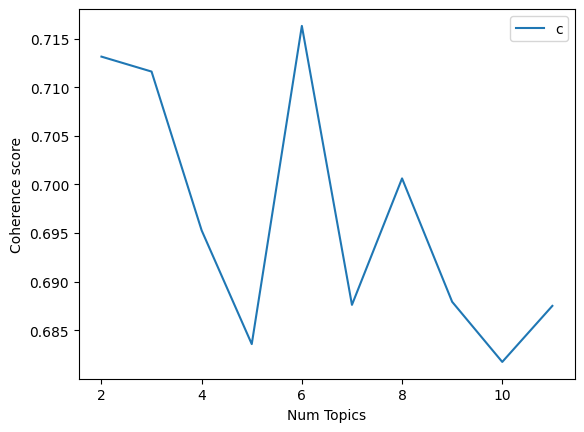

In [114]:
# Show graph
limit=12; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [115]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7131
Num Topics = 3  has Coherence Value of 0.7116
Num Topics = 4  has Coherence Value of 0.6953
Num Topics = 5  has Coherence Value of 0.6836
Num Topics = 6  has Coherence Value of 0.7163
Num Topics = 7  has Coherence Value of 0.6876
Num Topics = 8  has Coherence Value of 0.7006
Num Topics = 9  has Coherence Value of 0.6879
Num Topics = 10  has Coherence Value of 0.6817
Num Topics = 11  has Coherence Value of 0.6875


In [116]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.067*"inflación" + 0.067*"creer" + 0.067*"gustar" + 0.051*"red" + '
  '0.035*"mujer" + 0.035*"ministerio" + 0.035*"situación" + 0.035*"problema" + '
  '0.035*"inseguridad" + 0.035*"marcha"'),
 (1,
  '0.097*"tener" + 0.061*"decir" + 0.050*"gente" + 0.050*"muchísimo" + '
  '0.038*"hacer" + 0.038*"verdad" + 0.038*"pasar" + 0.026*"piquete" + '
  '0.026*"pelea" + 0.026*"dolor"'),
 (2,
  '0.082*"gente" + 0.055*"tema" + 0.042*"gobierno" + 0.042*"ver" + '
  '0.029*"tener" + 0.029*"político" + 0.029*"coincido" + 0.029*"capacidad" + '
  '0.029*"conducción" + 0.029*"nación"'),
 (3,
  '0.065*"hacer" + 0.065*"cosa" + 0.053*"mirar" + 0.040*"plan" + '
  '0.040*"manejar" + 0.040*"presidente" + 0.027*"cantidad" + 0.027*"dentro" + '
  '0.027*"mejor" + 0.027*"perdón"'),
 (4,
  '0.072*"virtud" + 0.054*"encontrar" + 0.054*"gobierno" + 0.054*"mujer" + '
  '0.054*"ocupar" + 0.037*"ministerio" + 0.037*"hacer" + 0.037*"reducir" + '
  '0.037*"así" + 0.037*"tomar"'),
 (5,
  '0.082*"cambio" + 0.066*"junt

In [118]:
datos['text_lemma']

0                          [virtud, encontrar]
1       [sinceridad, brutal, difícil, difícil]
2      [creer, dejar, decir, legado, negativo]
3              [profundizar, muchísimo, pelea]
4                         [hacer, bien, mundo]
                        ...                   
246              [romper, árbol, puerta, casa]
247                            [pedir, perdón]
248                       [hacer, mejor, cosa]
249                                         []
250                                   [gracia]
Name: text_lemma, Length: 251, dtype: object

In [130]:
import pandas as pd
from collections import Counter
import nltk
nltk.download('punkt')  

df = pd.DataFrame(datos['text_lemma'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [131]:
tokens = df['text_lemma'].apply(lambda x: [word.lower() for word in x])  # convert all words to lowercase


In [132]:
tokens

0                          [virtud, encontrar]
1       [sinceridad, brutal, difícil, difícil]
2      [creer, dejar, decir, legado, negativo]
3              [profundizar, muchísimo, pelea]
4                         [hacer, bien, mundo]
                        ...                   
246              [romper, árbol, puerta, casa]
247                            [pedir, perdón]
248                       [hacer, mejor, cosa]
249                                         []
250                                   [gracia]
Name: text_lemma, Length: 251, dtype: object

In [135]:



words = [word for sublist in tokens for word in sublist] 
word_counts = Counter(words)

# print the top 10 words and their counts
print(word_counts.most_common(20))



[('tener', 22), ('hacer', 13), ('gente', 13), ('decir', 12), ('mujer', 10), ('creer', 9), ('ministerio', 9), ('plan', 8), ('verdad', 7), ('gobierno', 7), ('pasar', 7), ('gustar', 6), ('tema', 6), ('junto', 6), ('cambio', 6), ('cosa', 6), ('virtud', 5), ('encontrar', 5), ('muchísimo', 5), ('hoy', 5)]
